# 1. Importing relevant libraries and datasets

Let us start off with the usual work of importing all the required datasets and the libraries which will help us visualise the data and work on it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import norm, skew

In [2]:
df_train=pd.read_csv('../input/big-mart-sales-prediction/Train.csv')
df_test=pd.read_csv('../input/big-mart-sales-prediction/Test.csv')

# 2. Data Visualisation and Cleaning

In this section, we will try to check the cleanliness of the data to understand how easily we can feed it to our ML algorithms

We shall also check the various descriptions of the columns to understand what they actually mean.

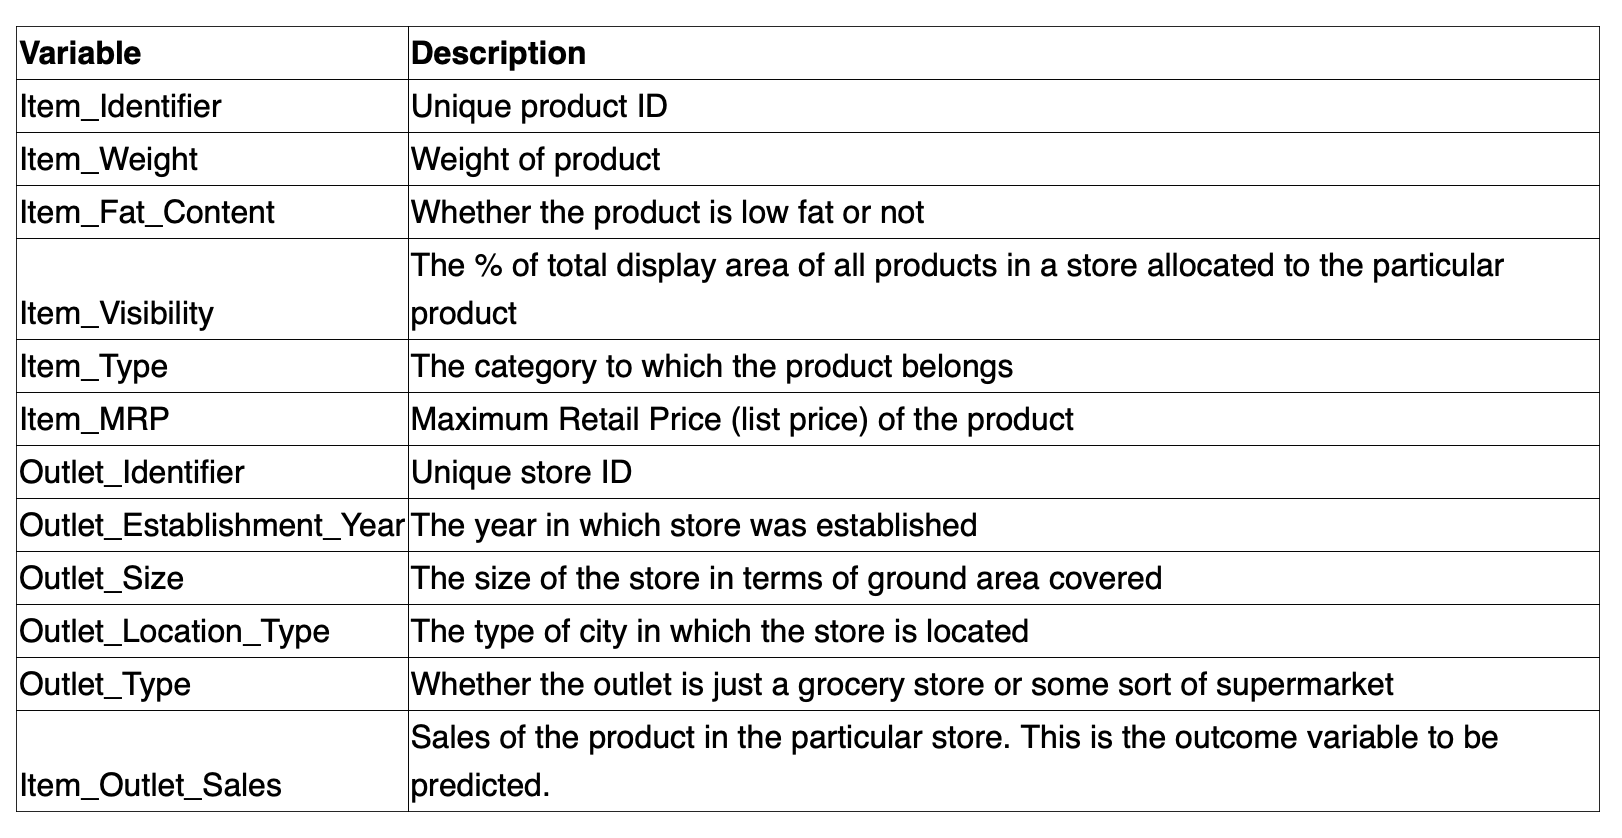

In [3]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Upon eyeballing into the data, we see that we have various datatypes for each feature here. We will try to check each of them out one by one to understand how we should treat the bad values. First of all, let us check the various datatypes.

In [4]:
df_train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

As we know, all ML models only understand input data in the form of numbers. Hence, we will be required to convert the values into numbers through the process of label encoding or one hot encoding technique. This is something we will deal with in the later stage of our analysis.

Let us check the number of null values we have at the moment.

In [5]:
df_train.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

From the above, we see that only two columns have null values associated with them which are Item_Weight and Outlet_Size. Let us visualise it with a heatmap.

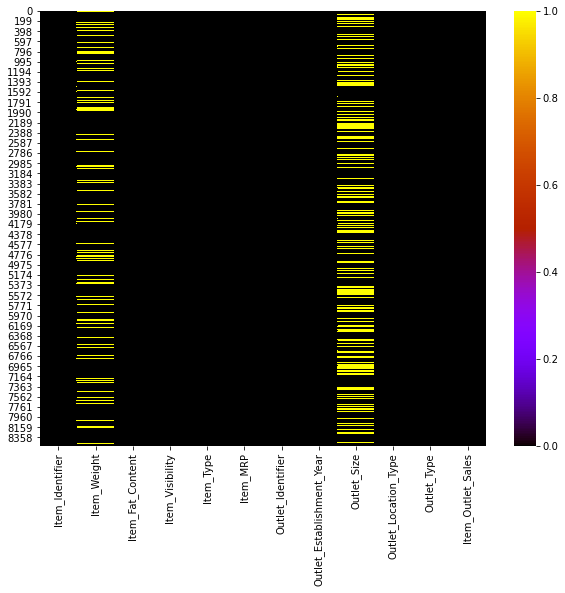

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.isna(),cmap='gnuplot')

The yellow marks show presence of null values. We have quite a few null values in these two columns that will need to be sorted out. We shall look into that a little later.

Let us first visualise the various data starting from Item_Weight.

## a) Item Weight

In [7]:
df_train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

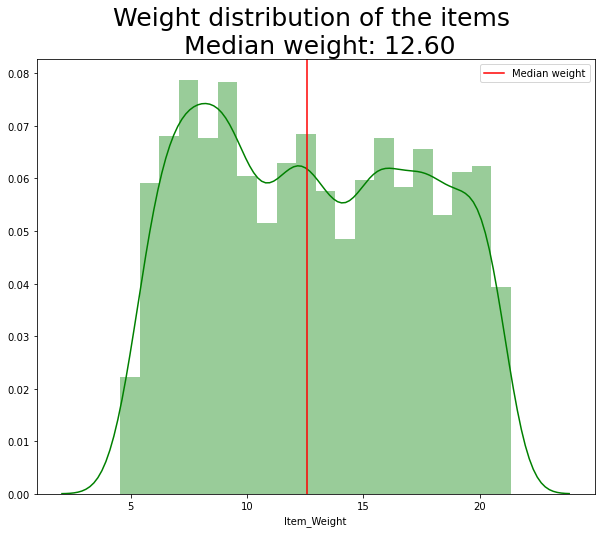

In [8]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Weight'].dropna(),color='green')
plt.title('Weight distribution of the items \n Median weight: {0:.2f}'.format(df_train['Item_Weight'].dropna().median()),size=25)
plt.axvline(df_train['Item_Weight'].dropna().median(),color='red',label='Median weight')
plt.legend()

Text(0.5, 1.0, 'Violinplot of weights')

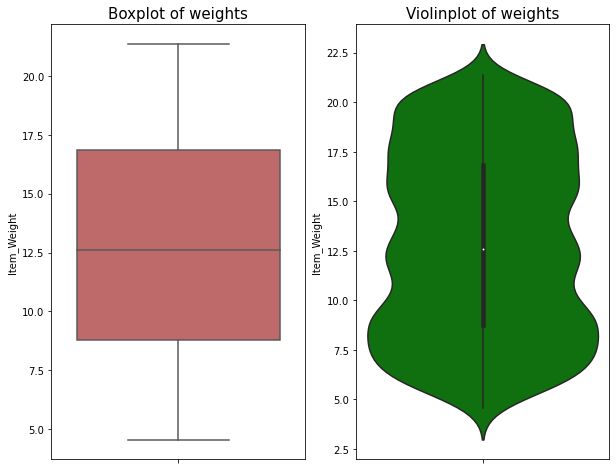

In [9]:
fig1=plt.figure(figsize=(10,8))
ax1=fig1.add_subplot(121)
sns.boxplot(df_train['Item_Weight'],ax=ax1,orient='v',color='indianred')
ax1.set_title('Boxplot of weights',size=15)

ax2=fig1.add_subplot(122)
sns.violinplot(df_train['Item_Weight'],ax=ax2,orient='v',color='green')
ax2.set_title('Violinplot of weights',size=15)

As we can see from the above violin and distplot, the curve platueus over a large range of weights. Hence, it is simply not possible for us to assume a weight for the null values. We shall leave them as it is or drop them if it is later deemed to not be too important in our analysis.

## b) Item_Fat_Content

Let us check the fat content column.

In [10]:
df_train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

We see bit of an issue in this column. Technically, we have only two unique values which are either low fat or regular. However, since the data entry has been done in separate ways, it is showing up as 5 unique values. Let us take care of it right now.

In [11]:
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('low fat','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('LF','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('reg','Regular')
df_train['Item_Fat_Content'].unique()


array(['Low Fat', 'Regular'], dtype=object)

Seems like we have solved the issue. Let us now visualise the number of items of each fat content.

In [12]:
df_train['Count']=1
df_fat=df_train.groupby('Item_Fat_Content')['Count'].sum().reset_index()

fig2=px.pie(df_fat,values='Count',names='Item_Fat_Content',hole=0.4)

fig2.update_layout(title='Fat content',title_x=0.48,
                  annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig2.update_traces(textfont_size=15,textinfo='percent+label')
fig2.show()

We see that about 64.7 % items are of low fat. This assumes that majority of customers are health conscious and prefer food with lower fat rating.

## Item_Visibility

Let us see how the item visibility of our products is distributed.

In [13]:
df_train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

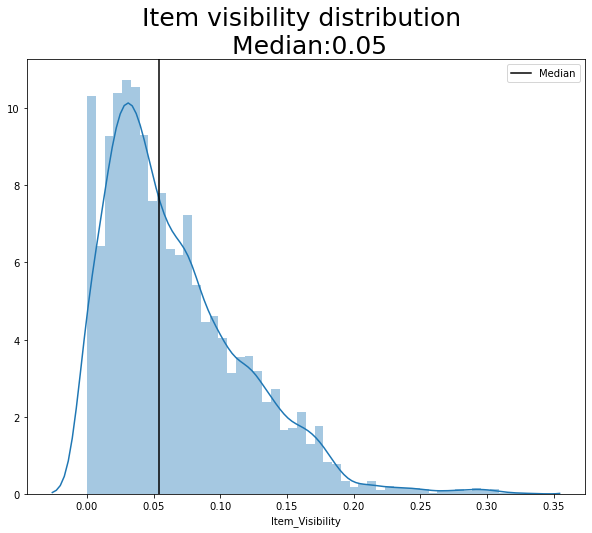

In [14]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'])
plt.title('Item visibility distribution \n Median:{0:.2f}'.format(df_train['Item_Visibility'].median()),size=25)
plt.axvline(df_train['Item_Visibility'].median(),color='black',label='Median')
plt.legend()

As we see from the curve, the item visibility has a right skew. Hence, a median would give us better indication than a mean value. Let us check for outliers if any.

((array([-3.77092014, -3.54353752, -3.4185981 , ...,  3.4185981 ,
          3.54353752,  3.77092014]),
  array([0.        , 0.        , 0.        , ..., 0.32111501, 0.32578081,
         0.32839095])),
 (0.04934877527401508, 0.06613202877895105, 0.9560728731678179))

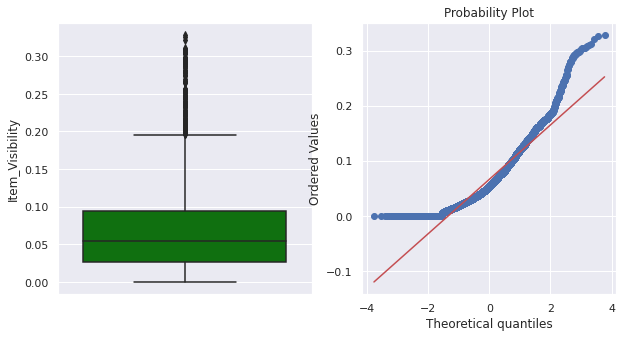

In [15]:
sns.set()
fig3=plt.figure(figsize=(10,5))
ax1=fig3.add_subplot(121)
sns.boxplot(df_train['Item_Visibility'],orient='v',ax=ax1,color='green')
ax2=fig3.add_subplot(122)
stats.probplot(df_train['Item_Visibility'],plot=ax2)

As we can see, values above 0.2 visibility are outliers. Presence of outliers don't bode well with machine learning algos. Hence, we need to remove the outliers and try to form a normal distribution.

The probplot also seems to suggest that the values are deviating from the normal values after 0.2

Let us check the number entries with item visibility above 0.2 as outliers.

In [16]:
df_train[df_train['Item_Visibility']>0.2].shape[0]

134

Hence, out of the approximately 8300 entries, we have only 134 entries which are outliers. It would serve us well to simply remove these entries.

((array([-3.7669643 , -3.53935697, -3.41428343, ...,  3.41428343,
          3.53935697,  3.7669643 ]),
  array([0.        , 0.        , 0.        , ..., 0.19899855, 0.19993588,
         0.19995527])),
 (0.04487626591626393, 0.06322235269591131, 0.9681235088881059))

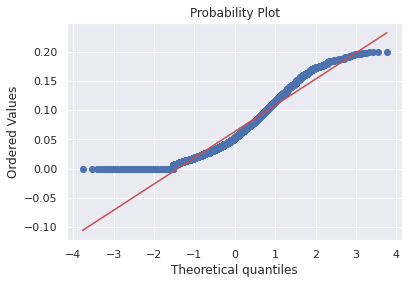

In [17]:
df_train=df_train[df_train['Item_Visibility']<0.2]
stats.probplot(df_train['Item_Visibility'],plot=plt)

Now, we see that the values above 0 are following a normal distribution to some extent. Let us check the deviation once more.

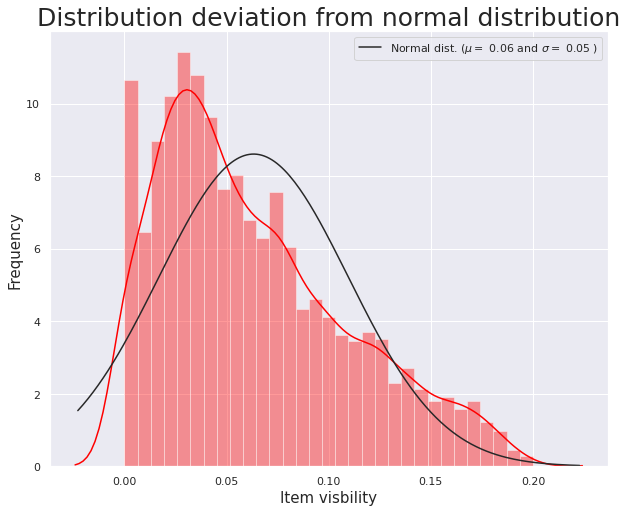

In [18]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'],fit=norm,color='red')
plt.title('Distribution deviation from normal distribution',size=25)
plt.ylabel('Frequency',size=15)
plt.xlabel('Item visbility',size=15)
mu=df_train['Item_Visibility'].mean()
sigma=df_train['Item_Visibility'].std()
plt.legend(['Normal dist. ($\mu=$ {0:.2f} and $\sigma=$ {1:.2f} )'.format(mu, sigma)])

This is as close to a normal distribution I could get for our model.

## c) Item_Type

Let us check how the item types are distributed through a pie plot.

In [19]:

df_type=df_train.groupby('Item_Type')['Count'].sum().reset_index()
fig4=px.sunburst(df_train,path=['Item_Type','Item_Fat_Content'],names='Item_Type',color_continuous_scale='RdBu')
fig4.update_layout(title='Item types',title_x=0.2,title_y=0.8,
                  annotations=[dict(showarrow=True,height=1000,width=900)],margin=dict(l=20, r=20, t=20, b=20))
fig4.show()

fig5=px.pie(df_type,values='Count',names='Item_Type')
fig5.update_layout(title='Item distribution',title_x=0.1,title_y=0.8)
fig5.update_traces(textfont_size=15,textinfo='percent')
fig5.show()

From the above plot, we see that fruits and vegetables were the highest sold item followed closely by Snack foods.


## d) Item_MRP

MRP is the max retail prices of the products. Let us check how the values are distributed in total.

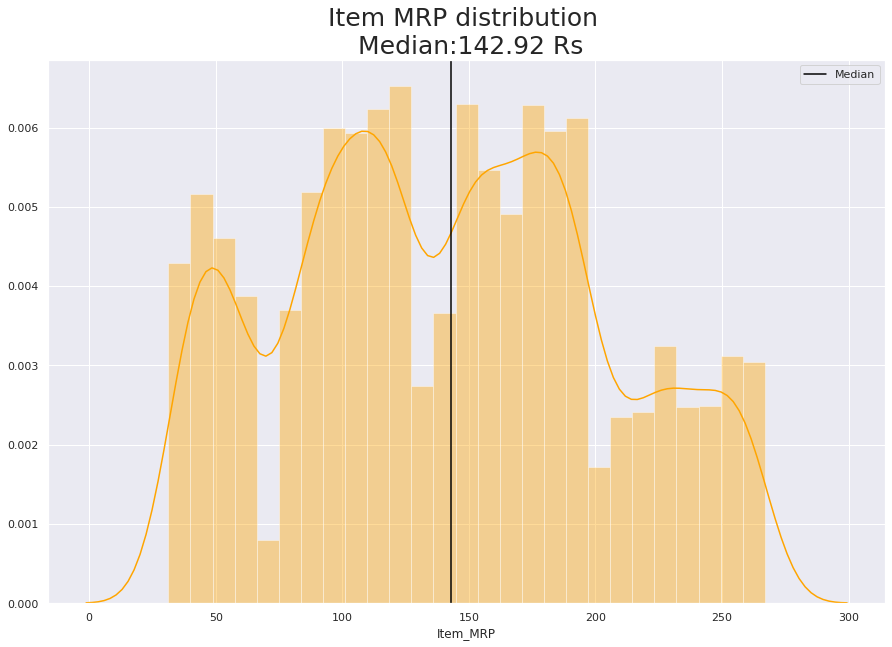

In [20]:
plt.figure(figsize=(15,10))
sns.distplot(df_train['Item_MRP'],color='orange')
plt.title('Item MRP distribution \n Median:{0:.2f} Rs'.format(df_train['Item_MRP'].median()),size=25)
plt.axvline(df_train['Item_MRP'].median(),color='black',label='Median')
plt.legend()

As we can see, we don't have any clear distribution of the prices here. The distribution is multi modal in nature with mulitple peaks.

The graph basically: 
* we have fair number of products whose prices range from 25-75 Rs.
* we have fair number of products in the 80-120 Rs range. Infact, it is the highest.
* the products increase again from 150-200 Rs range.
* There are fair number of products from 220-240 Rs range aswell.


Let us try to check the boxplots of how MRPs change with item products.

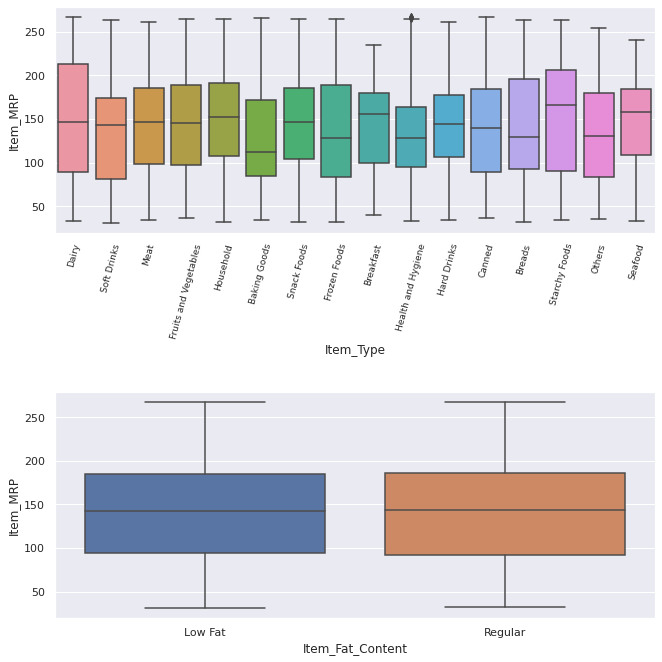

In [21]:
labels=df_train['Item_Type'].unique()
fig6=plt.figure(figsize=(10,10))
ax1=fig6.add_subplot(211)
sns.boxplot(x='Item_Type',y='Item_MRP',data=df_train,ax=ax1)
ax1.set_xticklabels(labels, rotation=75,size=9)

ax2=fig6.add_subplot(212)
sns.boxplot(x='Item_Fat_Content',y='Item_MRP',data=df_train,ax=ax2)

fig6.tight_layout(pad=3) #For spacing between subplots

From the above plot, we see which item types have high MRPs. Dairy product and Starchy foods have a higher median price than the rest.

Both low and regular food have almost identical median price.


## e) Outlet_Identifier

Let us see which outlets are selling well.

In [22]:
df_outlets=df_train.groupby('Outlet_Identifier')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)

([<matplotlib.axis.YTick at 0x7f1a158fde50>,
 <a list of 11 Text major ticklabel objects>)

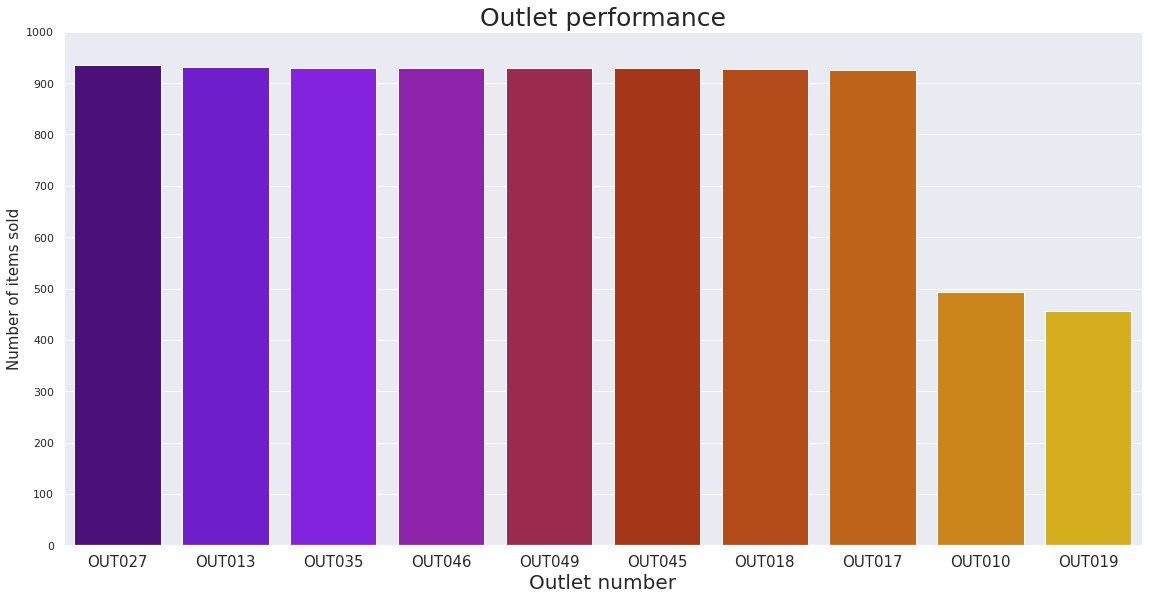

In [23]:
sns.catplot('Outlet_Identifier','Count',data=df_outlets,aspect=2,height=8,kind='bar',palette='gnuplot')
plt.xticks(size=15)
plt.ylabel('Number of items sold',size=15)
plt.xlabel('Outlet number',size=20)
plt.title('Outlet performance',size=25)
plt.yticks(np.arange(0,1100,100))

As we can see, most of the outlets have performed similarly with approximately 950 items sold. Outlet 10 and 19 are however lagging behind in sales.

## f) Outlet_Establishment_Year

Let us see if establishment year of the stores have any correlation with mean prices of items sold.

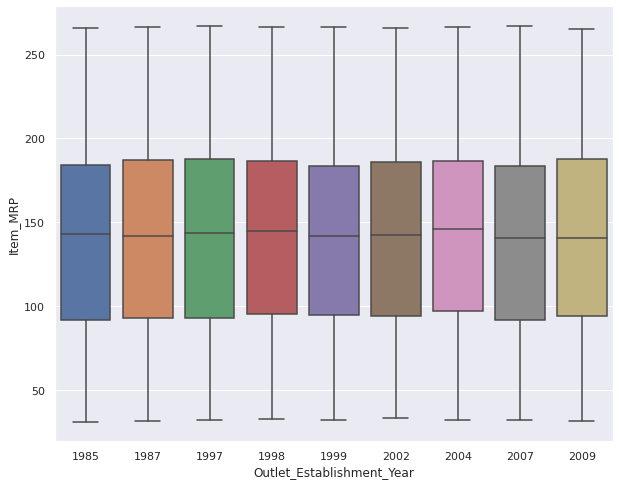

In [24]:
plt.figure(figsize=(10,8))
sns.boxplot('Outlet_Establishment_Year','Item_MRP',data=df_train)

As we can see, no matter how old the shops are, the median prices of items sold is nearly the same. Hence, customers have no bias to buy more expensive products from older or newer markets.


Let us now check if the establishment year has anything to do with number of output sales.

Text(0.5, 1.0, 'Outlet sales')

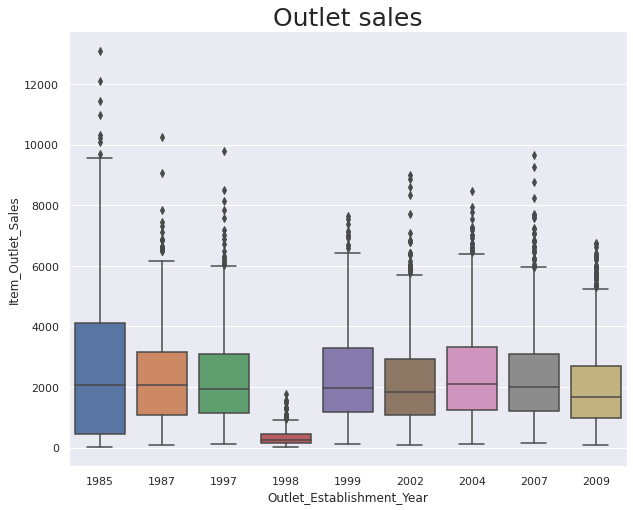

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot('Outlet_Establishment_Year','Item_Outlet_Sales',data=df_train)
plt.title('Outlet sales',size=25)

As it can be seen, the sales reported by the older stores is higher than the relatively newer stores (except for the 1998 established store)

## g) Outlet_Size

This feature deals with how big is the size of the outlet store. This field also contains empty values. Let us see if we can deal with these null values in any manner or simply discard it.

In [26]:
df_train['Outlet_Size'].isna().value_counts()

False    6041
True     2348
Name: Outlet_Size, dtype: int64

About 2348 instances have null values which is quite a sizeable amount.

In [27]:
df_size=df_train.groupby('Outlet_Size')['Count'].sum().reset_index()
fig7=px.pie(df_size,values='Count',names='Outlet_Size',hole=0.4)
fig7.update_layout(title='Store sizes',title_x=0.5,annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig7.update_traces(textfont_size=15,textinfo='percent+label')
fig7.show()

As we can see, maximum stores fall into the medium category followed by small. Only 15% stores are high sized stores.

In [28]:
df_size_sales=df_train.groupby('Outlet_Size')[['Item_MRP','Item_Outlet_Sales']].mean().reset_index()

In [29]:
df_size_sales

,Outlet_Size,Item_MRP,Item_Outlet_Sales
0,High,141.425982,2298.995256
1,Medium,140.590514,2681.603542
2,Small,141.756737,1960.412740


Text(0.5, 1.0, 'Average sales of store')

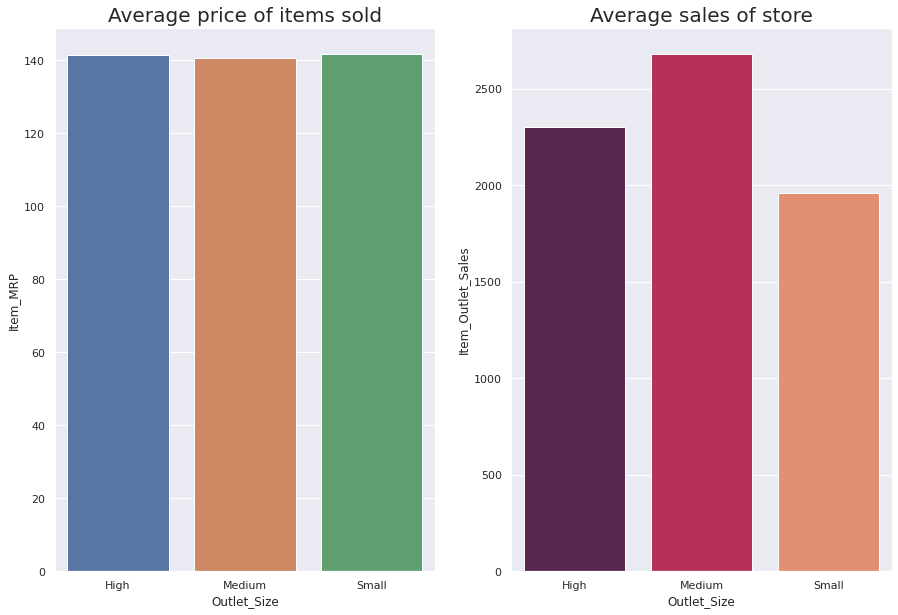

In [30]:
fig8=plt.figure(figsize=(15,10))
ax1=fig8.add_subplot(121)
sns.barplot('Outlet_Size','Item_MRP',data=df_size_sales,ax=ax1)

ax2=fig8.add_subplot(122)
sns.barplot('Outlet_Size','Item_Outlet_Sales',data=df_size_sales,ax=ax2,palette='rocket')

ax1.set_title('Average price of items sold',size=20)
ax2.set_title('Average sales of store',size=20)



The average price of items sold in each outlet store size is nearly the same which is Rs 140. However, The medium stores seem to sell better followed by high sized and then small sized stores.

## h) Outlet_Location_Type and Outlet_Type

Let us try to analyse if the outlet location type and outlet_type has any correlation with MRP of items sold and outlet sales.

In [31]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Count
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,1
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,1
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,1
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,1


In [32]:
fig9=px.sunburst(df_train,path=['Outlet_Type','Outlet_Location_Type'],color_continuous_scale='RdBu')
fig9.update_layout(title='Store type with location type',title_x=0.5)
fig9.show()

As we can see, majoirty of the stores are of type 1 supermarket distributed over various location tiers.

Supermarket type 2 and 3 are confined to only tier 3 locations. Very small section of the stores are actually grocery stores.

Let us check how do these stores sell based on location tier using a boxplot.

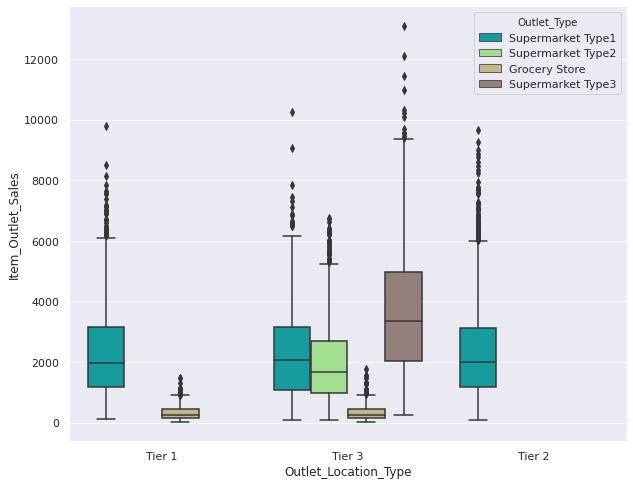

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(y='Item_Outlet_Sales',hue='Outlet_Type',x='Outlet_Location_Type',data=df_train,palette='terrain')

As we can see, tier 3 locations seem to be selling better than both tier 2 and tier 1. It is also to be noted that tier 3 has more number of stores in it. Hence, the sales are better too.


## i) Correlation heatmap

Now that we have inspected each of the features individually, we will try to check the correlations of each term with the other.

In [34]:
df_train.drop('Count',axis=1,inplace=True)

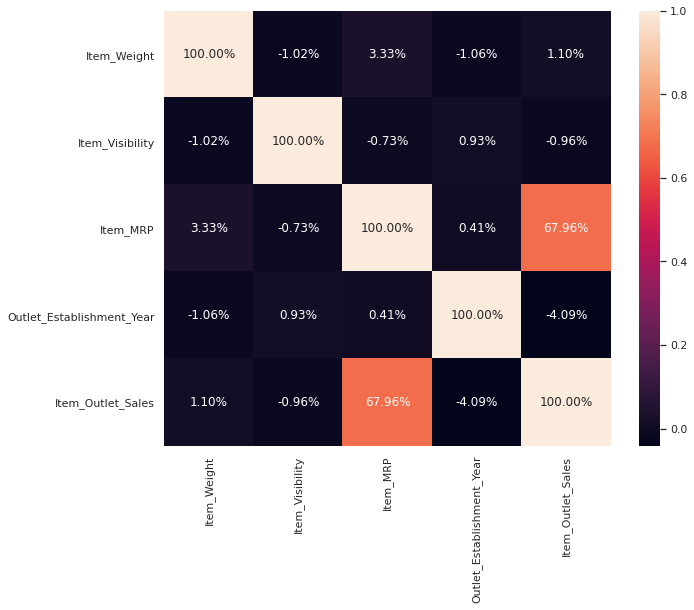

In [35]:
corrs=df_train.dropna().corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs,annot=True,fmt='.2%')

From the above, we can see that correlation of Item_Weight is extremely low. Hence, we can simply drop this column and get done with the issues of null values. We shall similarly remove the order_size as there is no way to deal with the null values here aswell. We would also get rid of the item_identifier and outlet_indetifier since it is of no consequence to us.

In [36]:
unn_cols=['Item_Weight','Outlet_Size','Item_Identifier','Outlet_Identifier']

for cols in unn_cols:
    df_train.drop(cols,axis=1,inplace=True)

# 4. Data Wrangling

Let us wrangle the data so that we can help make the dataframe into something that the ML algo can understand.

The main issue with the data given to us is the presence of categorical data. Let us handle these categorical data by using either label or one-hot encoding.

### Item_Fat_Content

Let us label the fat contents as 

* Low Fat: 1
* Regular: 0

In [37]:
df_train['Item_Fat_Content'].replace('Low Fat',1,inplace=True)
df_train['Item_Fat_Content'].replace('Regular',0,inplace=True)

### Item_Type

Here, we have multiple number of item types and it'll be quite difficult for us to label the items individually. Instead, what we could do is we can use one-hot-encoding.

In [38]:
df_dummies_type=pd.get_dummies(df_train['Item_Type'])

In [39]:
df_train=df_train.merge(df_dummies_type,on=df_train.index)

In [40]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Item_Type',axis=1,inplace=True)


### Outlet_Location_Type

Let us encode the Tiers 1,2,3 as simple numericals 1,2 and 3.

In [41]:
df_train['Outlet_Location_Type'].replace('Tier 1',1,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 2',2,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 3',3,inplace=True)

### Outlet_Type

We will use one-hot-encoding once more here.

In [42]:
df_dummies_outlet=pd.get_dummies(df_train['Outlet_Type'])
df_train=df_train.merge(df_dummies_outlet,on=df_train.index)

In [43]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Outlet_Type',axis=1,inplace=True)

### Item_Outlet_Sales

This is the target section for us which we will try to predict. Hence, we shall separate it out from the rest of the dataframe.

In [44]:
targets=df_train['Item_Outlet_Sales']
df_train.drop('Item_Outlet_Sales',axis=1,inplace=True)
df_train.head()

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,...,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,1,0.016047,249.8092,1999,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0.019278,48.2692,2009,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0.016760,141.6180,1999,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0.000000,182.0950,1998,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.000000,53.8614,1987,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


As we can see, the above dataframe is now completely numerical in nature and can be used for ML algorithm.

# 5. Machine Learning

## A) Training phase

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [46]:
X_train,X_test,y_train,y_test=train_test_split(df_train,targets,shuffle=True,test_size=0.2,random_state=0)

### Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
reg_lin=LinearRegression()
reg_lin.fit(X_train,y_train)

LinearRegression()

In [49]:
reg_lin.score(X_train,y_train)

0.5620345988855906

In [50]:
y_preds_lin=reg_lin.predict(X_test)

In [51]:
rmse_lin=np.sqrt(mean_squared_error(y_preds_lin,y_test))
print('RMSE for Linear Regression:{0:.2f}'.format(rmse_lin))

RMSE for Linear Regression:1130.81


Text(0.5, 1.0, 'Linear Regression \n RMSE: 1130.81')

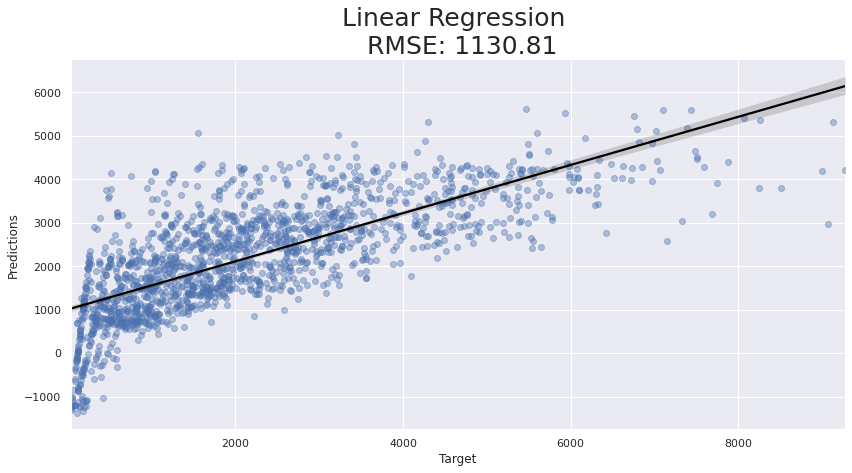

In [52]:
reg_lin_df=pd.DataFrame()
reg_lin_df['Target']=y_test
reg_lin_df['Predictions']=y_preds_lin

sns.lmplot('Target','Predictions',data=reg_lin_df,height=6,aspect=2,line_kws={'color':'black'},scatter_kws={'alpha':0.4})
plt.title('Linear Regression \n RMSE: {0:.2f}'.format(rmse_lin),size=25)

As we can see, the linear regression couldn't do a great job. The values are too scattered away from the black line which is the ideal region of the scatters. The RMSE is quite high too. Hence, it will definitely be a good option to check for regression techniques utilising a regularisation parameter such as Lasso and Ridge regression.

### Ridge Regression

We shall apply Ridge regression using a cross validation technique to prevent overfitting. We shall perform a 10 fold cross validation.

In [53]:
from sklearn.linear_model import RidgeCV

In [54]:
reg_rid=RidgeCV(cv=10)
reg_rid.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10)

In [55]:
reg_rid.score(X_train,y_train)

0.5619667255114942

In [56]:
y_preds_rid=reg_rid.predict(X_test)
rmse_rid=np.sqrt(mean_squared_error(y_preds_rid,y_test))
print('RMSE for Ridge Regression:{0:.2f}'.format(rmse_rid))

RMSE for Ridge Regression:1130.70


Text(0.5, 1.0, 'Ridge Regression \n RMSE: 1130.70')

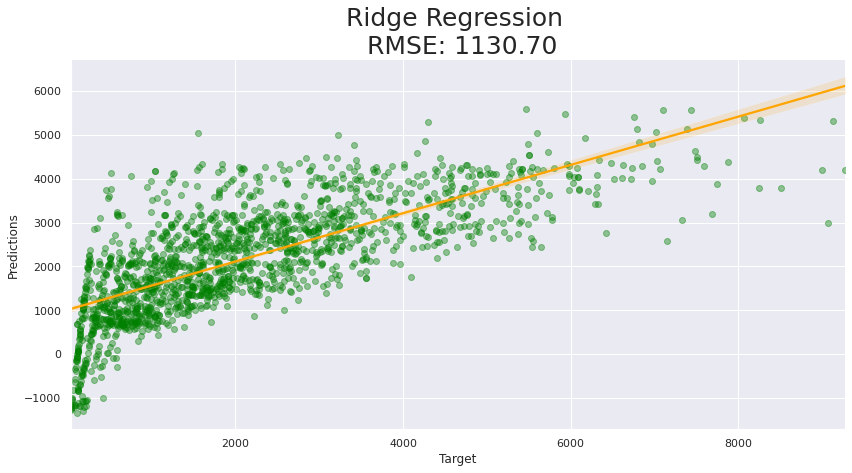

In [57]:
reg_rid_df=pd.DataFrame()
reg_rid_df['Target']=y_test
reg_rid_df['Predictions']=y_preds_rid

sns.lmplot('Target','Predictions',data=reg_rid_df,height=6,aspect=2,line_kws={'color':'orange'},scatter_kws={'alpha':0.4,'color':'green'})
plt.title('Ridge Regression \n RMSE: {0:.2f}'.format(rmse_rid),size=25)

As we can see, both linear and ridge regression have performed quite similarly with nearly identical RMSE scores.

### Lasso Regression

This is another regression technique that utlises the L1 regularisation. Let us see how it performs.

In [58]:
from sklearn.linear_model import Lasso

In [59]:
reg_las=Lasso()
reg_las.fit(X_train,y_train)

Lasso()

In [60]:
reg_las.score(X_train,y_train)

0.5617750843494751

In [61]:
y_preds_las=reg_las.predict(X_test)
rmse_las=np.sqrt(mean_squared_error(y_preds_las,y_test))
print('RMSE for Lasso Regression:{0:.2f}'.format(rmse_las))

RMSE for Lasso Regression:1128.80


Text(0.5, 1.0, 'Lasso Regression \n RMSE: 1128.80')

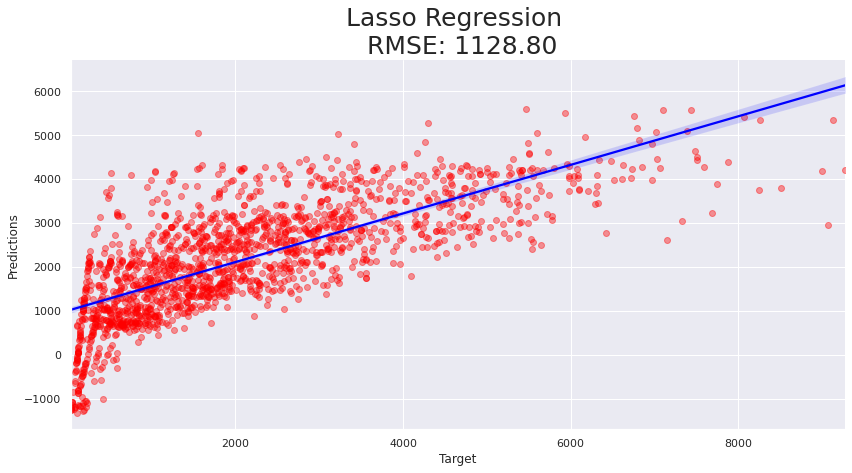

In [62]:
reg_las_df=pd.DataFrame()
reg_las_df['Target']=y_test
reg_las_df['Predictions']=y_preds_las

sns.lmplot('Target','Predictions',data=reg_las_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('Lasso Regression \n RMSE: {0:.2f}'.format(rmse_las),size=25)

From the above, we have realised that all the regression techniques with and without regularisations have yielded similar results.


## Ensemble methods

### Random Forest regression

Let us apply Random Forest regression using a hyperparameter tuning method called GridSearchCV where we shall change n_estimators and max_depth. We also apply a cross validation of 10.

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [64]:
rfr=RandomForestRegressor(random_state=0)
param_grid={'n_estimators':[3,4,5,7,9,10,12], 'max_depth':[5,7,9,10,12]}
grid=GridSearchCV(rfr,param_grid,scoring='r2',cv=10)

In [65]:
grid_result=grid.fit(X_train,y_train)
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [66]:
grid_result.score(X_train,y_train)

0.6037626015518893

In [67]:
y_preds_rfr=grid_result.predict(X_test)
rmse_rfr=np.sqrt(mean_squared_error(y_preds_rfr,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_rfr))

RMSE for Random Forest Regression:1077.74


Text(0.5, 1.0, 'Random Forest Regression \n RMSE: 1077.74')

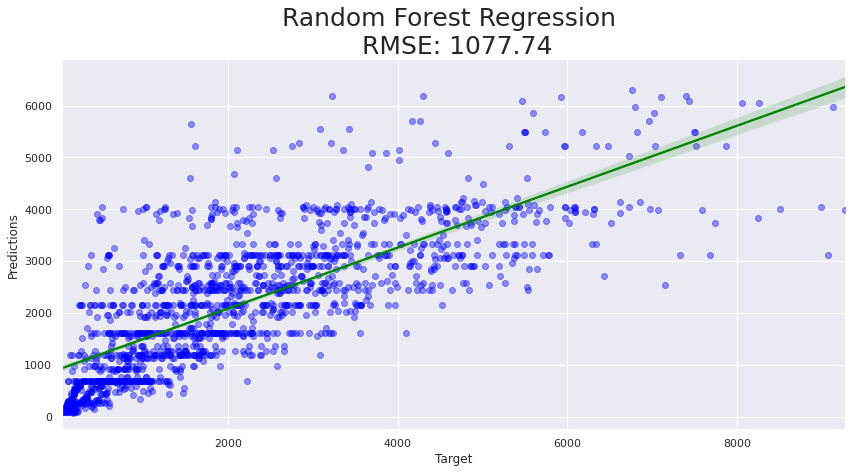

In [68]:
rfr_df=pd.DataFrame()
rfr_df['Target']=y_test
rfr_df['Predictions']=y_preds_rfr

sns.lmplot('Target','Predictions',data=rfr_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'blue'})
plt.title('Random Forest Regression \n RMSE: {0:.2f}'.format(rmse_rfr),size=25)

From the above RMSE, it is observed that Random Forest regression technique has done better than Linear regression techniques.

### Gradient Boosted Decision Tree Regressor

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

In [70]:
gbdt=GradientBoostingRegressor(random_state=0)
gbdt.fit(X_train,y_train)
gbdt.score(X_train,y_train)

0.6313952890813279

In [71]:
y_preds_gbdt=gbdt.predict(X_test)
rmse_gbdt=np.sqrt(mean_squared_error(y_preds_gbdt,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_gbdt))

RMSE for Random Forest Regression:1080.07


Text(0.5, 1.0, 'GBDT Regression \n RMSE: 1080.07')

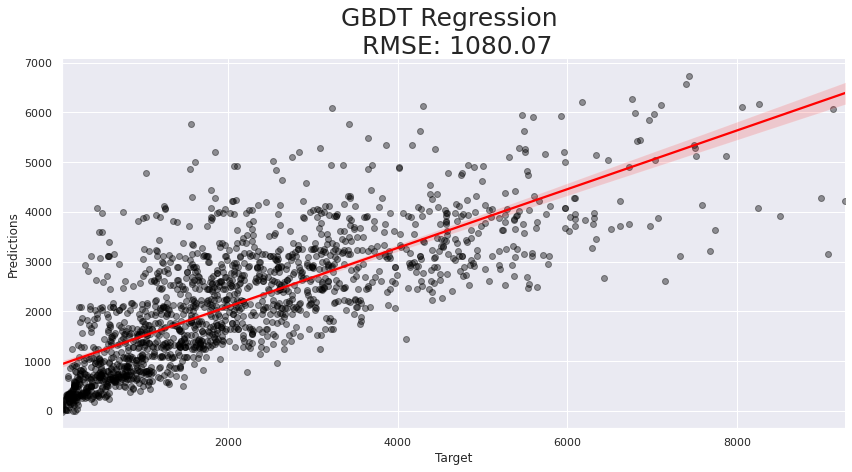

In [72]:
gbdt_df=pd.DataFrame()
gbdt_df['Target']=y_test
gbdt_df['Predictions']=y_preds_gbdt

sns.lmplot('Target','Predictions',data=gbdt_df,height=6,aspect=2,line_kws={'color':'red'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('GBDT Regression \n RMSE: {0:.2f}'.format(rmse_gbdt),size=25)

Both Random Forest and Gradient boosted decision tree have performed quite similar when compared on basis of RMSE.

### AdaBoostRegressor


In [73]:
from sklearn.ensemble import AdaBoostRegressor

In [74]:
ada=AdaBoostRegressor(random_state=0)
ada.fit(X_train,y_train)

AdaBoostRegressor(random_state=0)

In [75]:
y_preds_ada=ada.predict(X_test)
rmse_ada=np.sqrt(mean_squared_error(y_preds_ada,y_test))
print('RMSE for AdaBoost Regression:{0:.2f}'.format(rmse_ada))

RMSE for AdaBoost Regression:1225.99


Text(0.5, 1.0, 'AdaBoost Regression \n RMSE: 1225.99')

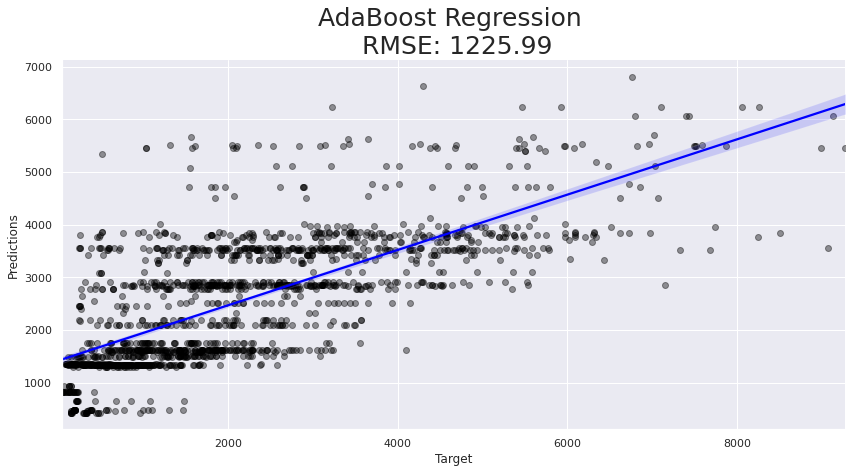

In [76]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_ada

sns.lmplot('Target','Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('AdaBoost Regression \n RMSE: {0:.2f}'.format(rmse_ada),size=25)

As we can see, AdaBoosted regression performed worse than all other models we have used so far.

### XGBoost regressor

In [77]:
import xgboost as xgb

In [78]:
xgb_reg=xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [79]:
xgb_reg.fit(X_train,y_train)
xgb_reg.score(X_train,y_train)

[11:58:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.733204940540473

In [80]:
y_preds_xgb=xgb_reg.predict(X_test)
rmse_xgb=np.sqrt(mean_squared_error(y_preds_xgb,y_test))
print('RMSE for XGBoost Regression:{0:.2f}'.format(rmse_xgb))

RMSE for XGBoost Regression:1128.46


Text(0.5, 1.0, 'XGBoost Regression \n RMSE: 1128.46')

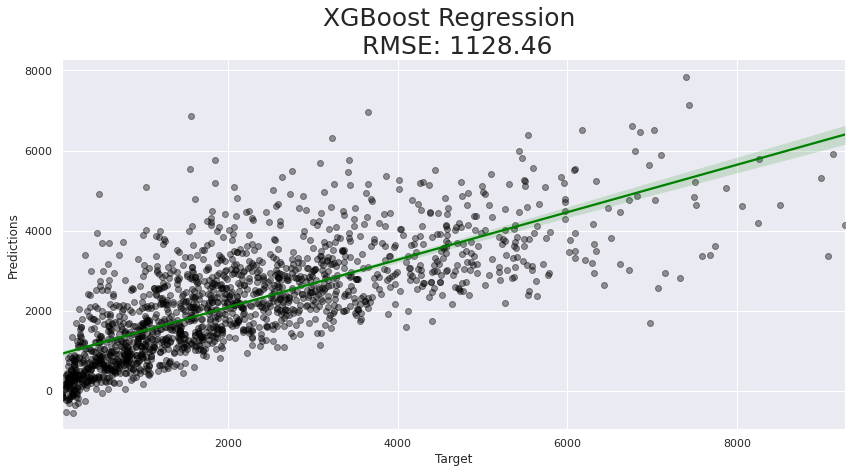

In [81]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_xgb

sns.lmplot('Target','Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('XGBoost Regression \n RMSE: {0:.2f}'.format(rmse_xgb),size=25)

XGboost could not perform as well as Random Forest or GBDT.

### LightGBM

In [82]:
from lightgbm import LGBMRegressor

In [83]:
lgb=LGBMRegressor(random_state=0)
lgb.fit(X_train,y_train)
lgb.score(X_train,y_train)

0.7069127746285484

In [84]:
y_preds_lgb=lgb.predict(X_test)
rmse_lgb=np.sqrt(mean_squared_error(y_preds_lgb,y_test))
print('RMSE for LGBM Regression:{0:.2f}'.format(rmse_lgb))

RMSE for LGBM Regression:1097.67


Text(0.5, 1.0, 'LGBM Regression \n RMSE: 1097.67')

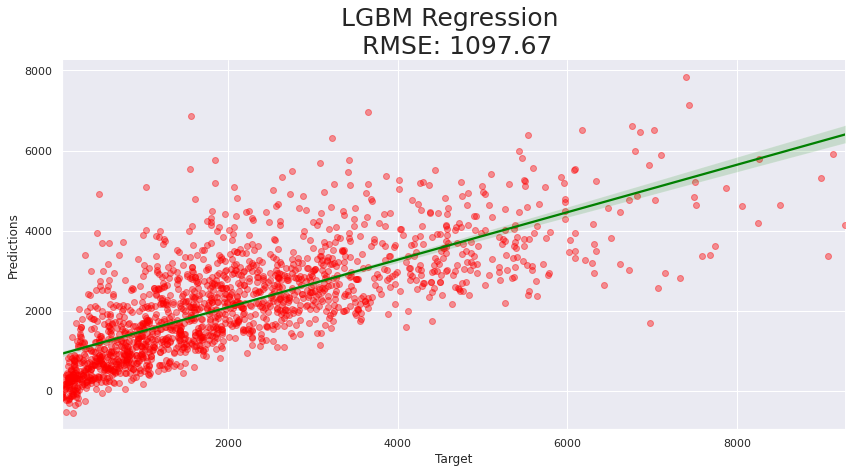

In [85]:
lgb_df=pd.DataFrame()
lgb_df['Target']=y_test
lgb_df['Predictions']=y_preds_lgb

sns.lmplot('Target','Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('LGBM Regression \n RMSE: {0:.2f}'.format(rmse_lgb),size=25)

## B) Testing Phase

Now that we have trained a few models, it is time for us to apply them to the test dataframe. For this, we need to align the dataframe exactly as the train dataframe. 

First, let us separate out the item and outlet identifiers as they are important to our final submission.

We will use the top 3 regressors for our solution submission which are **LGBM regressor, Random Forest regressor and GBDT regressor.**

In [86]:
df_identifiers=pd.DataFrame(df_test['Item_Identifier'])
df_identifiers['Outlet_Identifier']=df_test['Outlet_Identifier']

In [87]:

unn_cols=['Item_Weight','Outlet_Size','Item_Identifier','Outlet_Identifier']

for cols in unn_cols:
    df_test.drop(cols,axis=1,inplace=True)

In [88]:
df_test.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type
0,Low Fat,0.007565,Snack Foods,107.8622,1999,Tier 1,Supermarket Type1
1,reg,0.038428,Dairy,87.3198,2007,Tier 2,Supermarket Type1
2,Low Fat,0.099575,Others,241.7538,1998,Tier 3,Grocery Store
3,Low Fat,0.015388,Snack Foods,155.0340,2007,Tier 2,Supermarket Type1
4,Regular,0.118599,Dairy,234.2300,1985,Tier 3,Supermarket Type3


In [89]:
df_train.head()

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,...,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,1,0.016047,249.8092,1999,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0.019278,48.2692,2009,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0.016760,141.6180,1999,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0.000000,182.0950,1998,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.000000,53.8614,1987,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [90]:
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].replace('low fat','Low Fat')
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].replace('LF','Low Fat')
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].replace('reg','Regular')



In [91]:
df_test['Item_Fat_Content'].replace('Low Fat',1,inplace=True)
df_test['Item_Fat_Content'].replace('Regular',0,inplace=True)

In [92]:
df_dummies_type=pd.get_dummies(df_test['Item_Type'])
df_test=df_test.merge(df_dummies_type,on=df_test.index)


In [93]:
df_test.drop('key_0',axis=1,inplace=True)
df_test.drop('Item_Type',axis=1,inplace=True)                   
                    

In [94]:
df_test['Outlet_Location_Type'].replace('Tier 1',1,inplace=True)
df_test['Outlet_Location_Type'].replace('Tier 2',2,inplace=True)
df_test['Outlet_Location_Type'].replace('Tier 3',3,inplace=True)

In [95]:
df_dummies_outlet=pd.get_dummies(df_test['Outlet_Type'])
df_test=df_test.merge(df_dummies_outlet,on=df_test.index)

In [96]:
df_test.drop('key_0',axis=1,inplace=True)
df_test.drop('Outlet_Type',axis=1,inplace=True)

In [97]:
y_preds_rfr=grid_result.predict(df_test)
df_rfr_submission=df_identifiers
df_rfr_submission['Item_Outlet_Sales']=y_preds_rfr
df_rfr_submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1609.017103
1,FDW14,OUT017,1263.040194
2,NCN55,OUT010,583.257242
3,FDQ58,OUT017,2446.288967
4,FDY38,OUT027,5969.300166


In [98]:
df_rfr_submission.to_csv('RFR_submission.csv',index=False)